In [1]:
import sys
sys.path.append('/home/krish.shah/teobresums/Python')
import pycbc
import EOBRun_module
import numpy as np
import matplotlib.pyplot as plt
import time
sys.path.append('/home/krish.shah/GW_Lensing/Eccentric_Signals/')
import FF_computation_eccentric
from pycbc.waveform import utils
import scipy

from copy import deepcopy


In [2]:

##########################################################################################

"""
Contains functions relevant for fitting factor computation.
"""
def wrap_reflective( x, x1, x2):
    """
    Function to wrap and reflect a real number around the points x1 and x2. 
    Example - For spins, we will have 'wrap_reflective(1.1, -1, 1) = 0.9'; 'wrap_reflective(-1.1, -1, 1) = -0.9'; and so on.
    Parameters
    ----------
    x : float
        Value to be reflected.
    x1 : float
        The LHS reflective point.
    x2 : float
        The RHS reflective point.
    Returns
    -------
    float
        Wrapped and reflective value of x around x1 and x2.
    """        
    if x2 == None: #i.e., x2 can be unbounded
        x2 = 1e4   #assign a big number (but not np.inf as it will bias the algebra)
    period = 2*(x2 - x1)
    x_frac = (x - x1) % period
    if x_frac <= period/2:
        x_ref = x_frac + x1  
    elif x_frac > period/2:
        x_ref = (period - x_frac) + x1 
    return x_ref

    # function to wrap a real number periodically around the points x1 and x2. 
    # Ex- for a sine func, we will have 'periodic(2*np.pi + x, 0, 2*np.pi) = x'.
def wrap_periodic( x, x1, x2):
    """
    Function to wrap a real number periodically around the points x1 and x2. 
    Example - For spins, we will have 'wrap_periodic(2*np.pi + x, 0, 2*np.pi) = x'.
    Parameters
    ----------
    x : float
        Value to be reflected.
    x1 : float
        The LHS coordinate of boundary.
    x2 : float
        The RHS coordinate of boundary.
    Returns
    -------
    float
        Periodically wrapped value of x around x1 and x2.
    """    
    period = (x2 - x1)
    x_frac = (x - x1) % period
    x_p = x_frac + x1  
    return x_p

    # wraps x between (x1, x2) assuming boundaries to be either periodic or reflective.
def wrap( x, x1, x2, boundary='reflective'):
    """
    Function to wrap a real number around the points x1 and x2 either periodically or reflectively. 
    Example - (i) For spins, we will have 'wrap(2*np.pi + x, 0, 2*np.pi, 'periodic') = x';
    'wrap(1.1, -1, 1, 'reflective') = 0.9'; 'wrap(-1.1, -1, 1, 'reflective') = -0.9'.
    Parameters
    ----------
    x : float
        Value to be reflected.
    x1 : float
        The LHS coordinate of boundary.
    x2 : float
        The RHS coordinate of boundary.
    boundary : {'reflective', 'periodic'}, optional.
        Boundary type to conisder while wrapping. Default = 'reflective'.
    Returns
    -------
    float
        Periodically wrapped value of x around x1 and x2.
    Raises
    ------
    KeyError
        Allowed keywords for boundary are: {'reflective', 'periodic'}.
    """        
    if (boundary == 'reflective' or boundary == 'Reflective'):
        return wrap_reflective(x, x1, x2)
    elif (boundary == 'periodic' or boundary == 'Periodic'):
        return wrap_periodic(x, x1, x2)
    else:
        raise KeyError("Incorrect keyword provided for the argument 'boundary'. Allowed keywords are: {'reflective', 'periodic'}.")

def ext_sp( a):
    """
    Checks if the dimensionless spin magnitude `a` satisfies 0.998 < s < 1, otherwise assign a = 0.9.
    """
    if (abs(round(a, 3)) > 0.998):
        return 0.9*a/np.abs(a)
    else:
        return a

def dom_indv_sp( x):
    """
    Domain of an individual spin component: wrapping and reflection of real line around (-1, 1).
    
    """
    sp_ref = wrap(x, -1., 1., boundary='reflective')
    sp_ref = ext_sp(sp_ref)
    return sp_ref  

def dom_mag_sp( sp):
    """
    Domain of three spin components: ensures that spin magnitude is less than one for a given set of three spin components.
    """        
    try:
        assert len(sp) == 3, 'Spin should have three components [s_x, s_y, s_z], but entered spin has length = {} instead'.format(len(sp))
        sp = np.array(sp)
        a = np.linalg.norm([sp[0], sp[1], sp[2]])
        if a != 0:
            a_new = ext_sp(a)
            sp = a_new*sp/a
        return sp 
    except TypeError:
        return dom_indv_sp(sp) 
    
def dom_sp( sp):
    """
    Final combined function for wrapping of spin values - can handle both 3-component and 1-component spin values.
    Parameters
    ----------
    sp : {float, list}
        Spin value(s).
    Returns
    -------
    {float, list}
        Wrapped spin value(s).
    """
    try:  
        sp = list(map(lambda s: dom_indv_sp(s), sp))
        sp = dom_mag_sp(sp)
    except TypeError:
        sp = dom_indv_sp(sp)
    return sp 

def dom_m( x, m_min=3.5, m_max=None):
    """
    Returns wrapped mass value(s): wrapping and reflection of real line around (3.2, \inf), 
    where \inf is used so that `m > 3.2` is the only real restriction.
    Parameters
    ----------
    x : float
        Mass value to be wrapped within domain.
    m_min : float, optional
        Minimum mass to consider while wrapping. Default = 3.5.
    m_max : {None, float}, optional
        Maximum mass to consider while wrapping. Default = None.
    Returns
    -------
    float
        Wrapped Mass value within domain.
    """
    m_ref = wrap(x, m_min, m_max, boundary='reflective')
    return m_ref     

def dom_chirp( x, cm_min=3.05, cm_max=None):   # because chirp(3.5, 3.5) ~ 3.05
    """
    Returns wrapped Chirp Mass value(s): wrapping and reflection of real line around (3, 1e4), 
    where 1e4 is a large enough number so that `CM > 3` is the only real restriction.
    Parameters
    ----------
    x : float
        Chirp mass value to be wrapped within domain.
    cm_min : float, optional
        Minimum Chirp mass to consider while wrapping. Default = 3.5.
    cm_max : {None, float}, optional
        Maximum Chirp mass to consider while wrapping. Default = None.
    Returns
    -------
    float
        Wrapped Chirp Mass value within domain.
    """       
    cm_ref = wrap(x, cm_min, cm_max, boundary='reflective')
    return cm_ref   

    # domain of Mass Ratio values: wrapping and reflection of real line around (~0, 1).
def dom_q( x, q_min=1/18., q_max=1):
    """
    Returns wrapped mass ratio value(s): wrapping and reflection of real line around (~0, 1),
    assuming q = min(m1/m2, m2/m1) \in (0, 1).
    Parameters
    ----------
    x : float
        Mass ratio value to be wrapped within domain.
    q_min : float, optional
        Minimum mass ratio to consider while wrapping. Default = 3.5.
    q_max : {None, float}, optional
        Maximum mass ratio to consider while wrapping. Default = None.
    Returns
    -------
    float
        Wrapped mass ratio value within domain.
    """  
    x_wrap = wrap(x, q_min, q_max, boundary='reflective')
    return x_wrap

    # domain of Symmetric Mass Ratio values: wrapping and reflection of real line around (~0, 1/4).
def dom_eta( x, eta_min=0.05, eta_max=1/4.):
    """
    Returns wrapped symmetric mass ratio value(s): wrapping and reflection of real line around (~0, 1/4.).
    Parameters
    ----------
    x : float
        Mass ratio value to be wrapped within domain.
    eta_min : float, optional
        Minimum symmetric mass ratio to consider while wrapping. Default = 3.5.
    eta_max : {None, float}, optional
        Maximum symmetric mass ratio to consider while wrapping. Default = None.
    Returns
    -------
    float
        Wrapped symmetric mass ratio value within domain.
    """  
    x_wrap = wrap(x, eta_min, eta_max, boundary='reflective')
    return x_wrap 
    
def dom_ecc( x, ecc_min=0, ecc_max=0.9):
    x_wrap = wrap(x, ecc_min, ecc_max, boundary='reflective')
    return x_wrap 

def cyclic_time_shift_of_WF(wf, rwrap=0.2):
        """
        Inspired by PyCBC's function pycbc.types.TimeSeries.cyclic_time_shift(), 
        it shifts the data and timestamps in the time domain by a given number of seconds (rwrap). 
        Difference between this and PyCBCs function is that this function preserves the sample rate of the WFs while cyclically rotating, 
        but the time shift cannot be smaller than the intrinsic sample rate of the data, unlike PyCBc's function.
        To just change the time stamps, do ts.start_time += dt.
        Note that data will be cyclically rotated, so if you shift by 2 seconds, the final 2 seconds of your data will be patched to the initial part 
        of the signal, therevy also changing the start_time by -2 seconds.

        Parameters
        ----------
        wf : pycbc.types.TimeSeries
            The waveform for cyclic rotation.
        rwrap : float, optional
            Amount of time to shift the vector. Default = 0.2.

        Returns
        -------
        pycbc.types.TimeSeries
            The time shifted time series.

        """      
          

        # This function does cyclic time shift of a WF.
        # It is similar to PYCBC's "cyclic_time_shift" except for the fact that it also preserves the Sample Rate of the original WF.
        if rwrap is not None and rwrap != 0:
            #print((rwrap))
            #print(type(wf.delta_t))
            sn = abs(int(rwrap/wf.delta_t))     # number of elements to be shifted 
            cycles = int(sn/len(wf))

            cyclic_shifted_wf = wf.copy()

            sn_new = sn - int(cycles * len(wf))

            if rwrap > 0:
                epoch = wf.sample_times[0] - sn_new * wf.delta_t
                if sn_new != 0:
                    wf_arr = np.array(wf).copy()
                    tmp_wf_p1 = wf_arr[-sn_new:]
                    tmp_wf_p2 = wf_arr[:-sn_new] 
                    shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                    cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)
            else:
                epoch = wf.sample_times[sn_new]
                if sn_new != 0:
                    wf_arr = np.array(wf).copy()
                    tmp_wf_p1 = wf_arr[sn_new:] 
                    tmp_wf_p2 = wf_arr[:sn_new]
                    shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                    cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)  

            for i in range(cycles):        
                    epoch = epoch - np.sign(rwrap)*wf.duration
                    wf_arr = np.array(cyclic_shifted_wf)[:]
                    cyclic_shifted_wf = pycbc.types.TimeSeries(wf_arr, delta_t = wf.delta_t, epoch = epoch)

            assert len(cyclic_shifted_wf) == len(wf), 'Length mismatch: cyclic time shift added extra length to WF.'
            return cyclic_shifted_wf
        else:
            return wf

def dom_x( x, x_min=0.01, x_max=None):
    x_wrap = wrap(x, x_min, x_max, boundary='reflective')
    return x_wrap 

In [6]:

def overlap_wfs(rec,wf):
    rec = rec
    wf = wf    
    x0 = 0
    vals = scipy.optimize.minimize(optimse_func_2, x0, args=(wf,rec),method='Nelder-Mead',options = {'xatol': 1e-5})   
    #print(vals.fun)
    return 1 - vals.fun

def optimse_func_2(x, *args):
    wf, rec = deepcopy(args[0]), deepcopy(args[1])
    t_c = x
    f = rec.sample_frequencies
    rec *= np.exp(1j*(2*np.pi*f*t_c))
    overlap = pycbc.filter.matchedfilter.overlap(wf, rec, low_frequency_cutoff=20, high_frequency_cutoff=None, normalized=True)    
    #print(1-overlap)
    return 1-overlap

def objective_wf(x,*args):
    x[0], x[1] = dom_m(x[0]), dom_q(x[1])
    x[2] = dom_ecc(x[2])
    Mt, q = x[0],x[1]
    phi_c = x[3]
    
    prms = Mt , q, x[2], phi_c

    wf , kwargs = args
    rec = gen_wf(prms,**kwargs)
    #wavef, recov = deepcopy(wf), deepcopy(rec)

    flen = max(len(wf), len(rec))
    wf.resize(flen)
    rec.resize(flen)


    return 1 - overlap_wfs(rec,wf)

def gen_wf(prms,**kwargs ):

    Mt , q, ecc, phi_c = prms
    #print(prms)
    f_low=20
    k = [0,1,3,4]
    #print(prms)
    shifted_pars = {
        'M'                  : Mt,
        'q'                  : q,
        'chi1'               : 0.0,
        'chi2'               : 0.0,   
        'domain'             : 0,      #Set 1 for FD. Default = 0
        'inclination'        : kwargs['inclination'],
        'coalescence_angle'  : phi_c,
        'use_mode_lm'        : k,    #List of modes to use/output through EOBRunPy
        'output_lm'          : k,    #List of modes to print on file
        'srate_interp'       : 4096.,  #srate at which to interpolate. Default = 4096.
        'use_geometric_units': 0,      #output quantities in geometric units. Default = 1
        'ode_abstol'         : 1e-9,
        'ode_reltol'         : 1e-8,   
        'initial_frequency'  : f_low,     #in Hz if use_geometric_units = 0, else in geometric units
        'interp_uniform_grid': 1,      #interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
        'ecc'                : ecc,     #Eccentricity. Default = 0.
        'distance'           : 100,
        'ecc_freq'           : 2,      #Use periastron (0), average (1) or apastron (2) frequency for initial condition computation. Default = 1
        }  
    t, hp, hc = EOBRun_module.EOBRunPy(shifted_pars)
    merg = np.argmax(hp)
    t -= t[merg]
    rec = pycbc.types.timeseries.TimeSeries(hp,delta_t=t[1]-t[0],epoch=t[0])
    recf = rec.to_frequencyseries(delta_f =rec.delta_f)
    return recf


    
def gen_seed(Mtot,q,eccentricity,sigma_Mt=0.1,sigma_q = 0.01,sigma_ecc=0.02):

    Mtot_inj = np.random.normal(Mtot, sigma_Mt, 1)[0]
    q_inj = np.random.normal(q, sigma_q, 1)[0]
    ecc = np.random.normal(eccentricity, sigma_ecc, 1)[0]
    return[dom_m(Mtot_inj), dom_q(q_inj), dom_ecc(ecc)]



def compute_FF(signal,**kwargs):
    Mtot, q, eccentricity = kwargs['mt_inj'], kwargs['q_inj'], kwargs['ecc']
    seed_params = gen_seed(Mtot,q,eccentricity = eccentricity)
    #print(seed_params)
    x0 = [seed_params[0],seed_params[1],seed_params[2],-0.5]
    #print(x0)
    tmp_sig = deepcopy(signal)
    FF =  scipy.optimize.minimize(objective_wf, x0, args=(tmp_sig,kwargs), method='Nelder-Mead',options = {'xatol': 1e-5})   
    return [(1 - FF.fun),list(FF.x)]


In [5]:

q_inj = 1/3
l_inj = 0
mt_inj = 50
e_inj = 0.4
f_low =20
k = [0,1,3,4]
inj_pars = {
    'M'                  : mt_inj,
    'q'                  : q_inj,
    'chi1'               : 0.0,
    'chi2'               : 0.0,   
    'domain'             : 0,      #Set 1 for FD. Default = 0

    'inclination'        : l_inj,
    'use_mode_lm'        : k,    #List of modes to use/output through EOBRunPy
    'output_lm'          : k,    #List of modes to print on file
    'srate_interp'       : 4096.,  #srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,      #output quantities in geometric units. Default = 1
    'ode_abstol'         : 1e-9,
    'ode_reltol'         : 1e-8,
    'initial_frequency'  : 20,     #in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,      #interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'ecc'                : e_inj,     #Eccentricity. Default = 0.
    'distance'           : 100,
    'ecc_freq'           : 2,      #Use periastron (0), average (1) or apastron (2) frequency for initial condition computation. Default = 1

}

t1, hp1, hc1 = EOBRun_module.EOBRunPy(inj_pars)
merg = np.argmax(hp1)
t1 -= t1[merg]
hpt1 = pycbc.types.timeseries.TimeSeries(hp1,delta_t=t1[1]-t1[0],epoch=t1[0])
hpf = hpt1.to_frequencyseries(delta_f=hpt1.delta_f)
function = np.sqrt(1.0)*np.exp( -1j*np.pi/2)
hpf *= function
hpt12 = hpf.to_timeseries(delta_t = hpf.delta_t)

In [7]:
kwargs = dict(mt_inj = mt_inj, q_inj = q_inj, inclination = l_inj,ecc = e_inj)

def nruns(niters):
    #FF_value = np.zeros(niters)
    FV = []
    for i in range(niters):
        A  =  compute_FF(hpf,**kwargs)
        XY = [[A[0],A[1]]]
        FV += XY

    return FV

FF_V  = nruns(3)

In [8]:
FF_V

[[1.0612204850088154,
  [66.87785962100222,
   0.44733597037621076,
   0.28924113648339433,
   -0.7120639264070587]],
 [1.0623254362672487,
  [68.038476017302,
   0.4336649158649476,
   0.2843317836066357,
   -0.7159205797371393]],
 [1.037354402115325,
  [65.31466364971054,
   0.5591222499806776,
   0.2977444592886217,
   -0.3593758652654464]]]

In [13]:

q_inj = 1/9
l_inj = np.pi/3
mt_inj = 40
e_inj = 0.4
f_low =20
k = [0,1,3,4]
inj_pars = {
    'M'                  : mt_inj,
    'q'                  : q_inj,
    'chi1'               : 0.0,
    'chi2'               : 0.0,   
    'domain'             : 0,      #Set 1 for FD. Default = 0

    'inclination'        : l_inj,
    'use_mode_lm'        : k,    #List of modes to use/output through EOBRunPy
    'output_lm'          : k,    #List of modes to print on file
    'srate_interp'       : 4096.,  #srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,      #output quantities in geometric units. Default = 1
    'ode_abstol'         : 1e-9,
    'ode_reltol'         : 1e-8,
    'initial_frequency'  : 20,     #in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,      #interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'ecc'                : e_inj,     #Eccentricity. Default = 0.
    'distance'           : 100,
    'ecc_freq'           : 2,      #Use periastron (0), average (1) or apastron (2) frequency for initial condition computation. Default = 1

}

t1, hp1, hc1 = EOBRun_module.EOBRunPy(inj_pars)
merg = np.argmax(hp1)
t1 -= t1[merg]
hpt1 = pycbc.types.timeseries.TimeSeries(hp1,delta_t=t1[1]-t1[0],epoch=t1[0])
hpf = hpt1.to_frequencyseries(delta_f=hpt1.delta_f)
function = np.sqrt(1.0)*np.exp( -1j*np.pi/2)
hpf *= function
hpt12 = hpf.to_timeseries(delta_t = hpf.delta_t)

In [14]:

q_inj = 1/9
l_inj = np.pi/3
mt_inj = 40
e_inj = 0.4
f_low =20
k = [0, 1, 3, 4]
inj_pars = {
    'M'                  : mt_inj,
    'q'                  : q_inj,
    'chi1'               : 0.0,
    'chi2'               : 0.0,   
    'domain'             : 0,      #Set 1 for FD. Default = 0
    'coalescence_angle'  : -np.pi/4,
    'inclination'        : l_inj,
    
    'use_mode_lm'        : k,    #List of modes to use/output through EOBRunPy
    'output_lm'          : k,    #List of modes to print on file
    'srate_interp'       : 4096.,  #srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,      #output quantities in geometric units. Default = 1
    'ode_abstol'         : 1e-9,
    'ode_reltol'         : 1e-8,
    'initial_frequency'  : 20,     #in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,      #interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'ecc'                : e_inj,     #Eccentricity. Default = 0.
    'distance'           : 100,
    'ecc_freq'           : 2,      #Use periastron (0), average (1) or apastron (2) frequency for initial condition computation. Default = 1

}

t2, hp2, hc2 = EOBRun_module.EOBRunPy(inj_pars)
merg = np.argmax(hp2)
t2 -= t2[merg]
hpt2 = pycbc.types.timeseries.TimeSeries(hp2,delta_t=t2[1]-t2[0],epoch=t1[0])



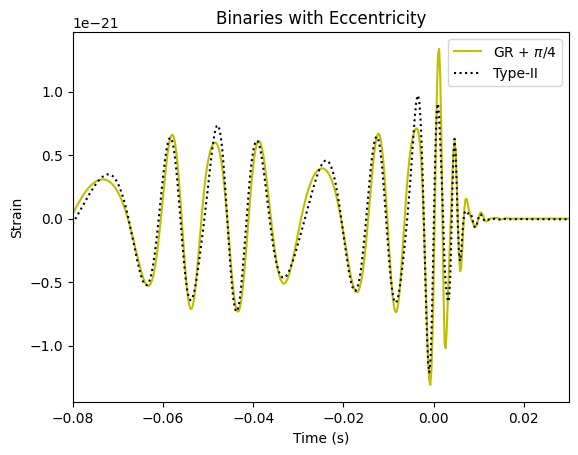

In [15]:

plt.plot(hpt2.sample_times,hpt2,'y', label=r'GR + $ \pi /4$')
plt.plot(hpt12.sample_times,hpt12,':k',label='Type-II')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.xlim(-0.08,0.03)
plt.legend()
plt.title('Binaries with Eccentricity')
plt.show()

In [24]:
from pycbc.waveform import get_td_waveform
mt_inj = 100.0 #Total mass injected
q_inj = 0.3 #mass ratio injected
l_inj = 0 #inclination injected
chi_eff_inj = 0.5
chi_p_inj = 0.5
inj_params = dict(approximant="IMRPhenomXPHM",
                         mass1=mt_inj / (1 + q_inj), 
                         mass2=mt_inj *q_inj  / (1 + q_inj), 
                         delta_t=1.0/4096, 
                         f_lower=20.0,
                         spin1z = 0,
                         spin2z = 0,
                         spin1x = chi_p_inj,
                         spin1y = 0,
                         spin2x = 0,
                         spin2y = chi_eff_inj,  
                         inclination=l_inj,
                         distance = 100,
                         #mode_array = [[2,2]],
                         delta_f =0.01)

#Wf generation
wfSP,_ = get_td_waveform(**inj_params)

wfSPfd = wfSP.to_frequencyseries() 
function = np.sqrt(1.0)*np.exp( -1j*np.pi/2)
wfSPfd *= function

wfSPL = wfSPfd.to_timeseries()

In [25]:
inj_params = dict(approximant="IMRPhenomXPHM",
                         mass1=mt_inj / (1 + q_inj), 
                         mass2=mt_inj *q_inj  / (1 + q_inj), 
                         delta_t=1.0/4096, 
                         f_lower=20.0,
                         spin1z = 0,
                         spin2z = 0,
                         spin1x = chi_p_inj,
                         spin1y = 0,
                         spin2x = 0,
                         spin2y = chi_eff_inj,  
                         coa_phase = -np.pi/4,
                         inclination=l_inj,
                         distance = 100,
                         #mode_array = [[2,2]],
                         delta_f =0.01)

wfSPS,_ = get_td_waveform(**inj_params)

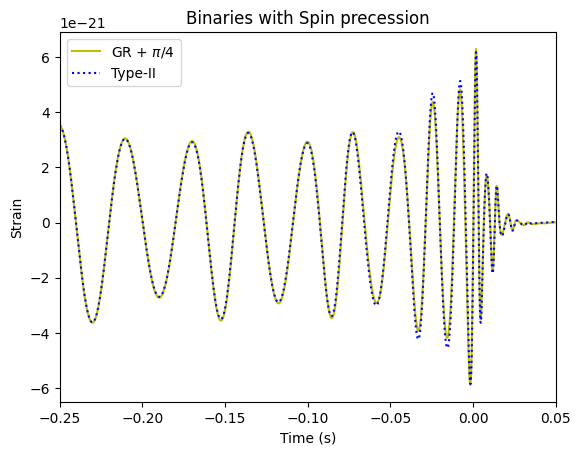

In [26]:
plt.plot(wfSPS.sample_times,wfSPS,'y', label=r'GR + $ \pi /4$')
plt.plot(wfSPL.sample_times,wfSPL,':b', label='Type-II')
plt.xlim(-0.25,0.05)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.title('Binaries with Spin precession')
plt.show()

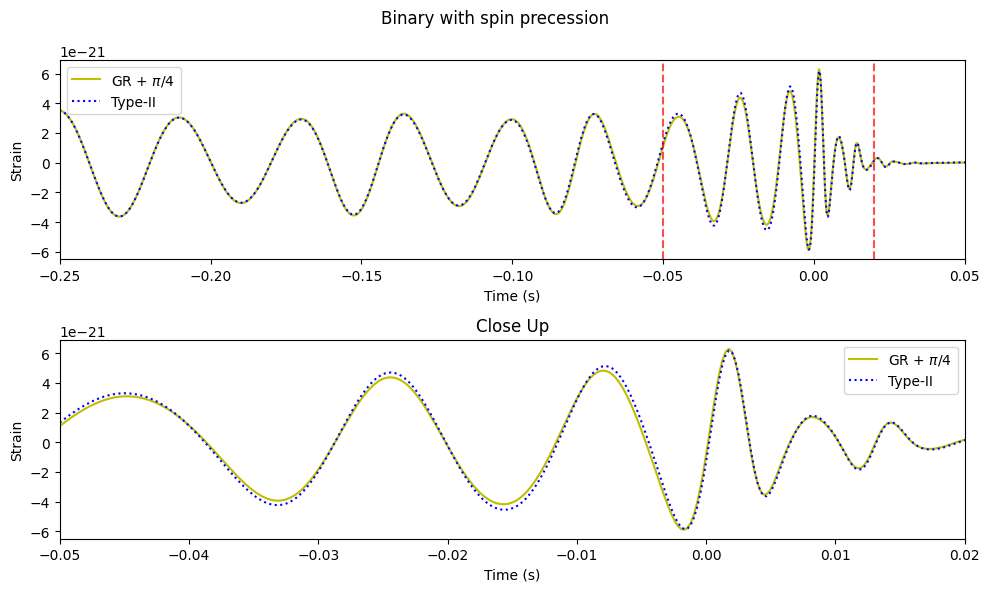

In [32]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

close_up_x_start, close_up_x_end = -0.05, 0.02

# Plot the entire data
plt.subplot(2, 1, 1)
plt.plot(wfSPS.sample_times,wfSPS,'y', label=r'GR + $ \pi /4$')
plt.plot(wfSPL.sample_times,wfSPL,':b', label='Type-II')
plt.axvline(close_up_x_start, color='red', linestyle='--', alpha=0.7)
plt.axvline(close_up_x_end, color='red', linestyle='--', alpha=0.7)
plt.xlim(-0.25,0.05)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()

# Choose the range for the close-up region


# Plot the close-up region
plt.subplot(2, 1, 2)
plt.plot(wfSPS.sample_times,wfSPS,'y', label=r'GR + $ \pi /4$')
plt.plot(wfSPL.sample_times,wfSPL,':b', label='Type-II')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.xlim(close_up_x_start, close_up_x_end)

plt.title('Close Up')
plt.legend()

# Add a vertical line to indicate the close-up region


# Show the plot
plt.suptitle('Binary with spin precession')
plt.tight_layout()  # Adjusts the spacing between subplots
plt.show()

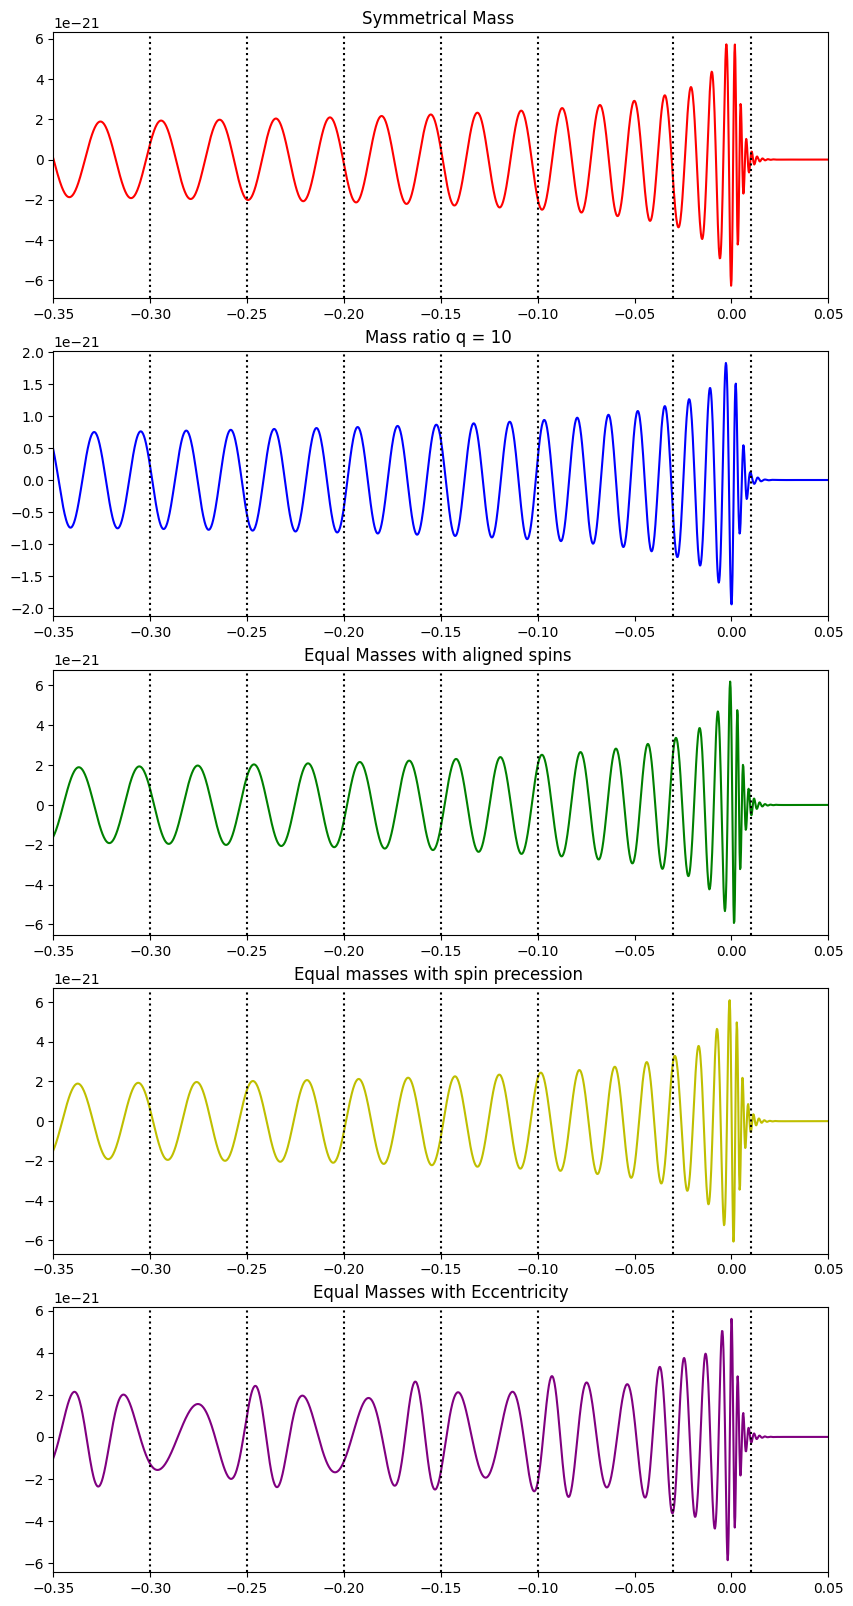

In [57]:
fig, axes = plt.subplots(5,1, figsize=(10, 20))
axes[0].plot(wfnorm.sample_times,wfnorm,'r')
axes[0].set_xlim(-0.35,0.05)

axes[1].plot(wfHM.sample_times,wfHM,'b')
axes[1].set_xlim(-0.35,0.05)

axes[3].plot(wfSP.sample_times,wfSP,'y')
axes[3].set_xlim(-0.35,0.05)

axes[2].plot(wfASP.sample_times,wfASP,'g')
axes[2].set_xlim(-0.35,0.05)

axes[4].plot(wfEcc.sample_times,wfEcc,'purple')
axes[4].set_xlim(-0.35,0.05)

axes[0].set_title('Symmetrical Mass ')
axes[1].set_title('Mass ratio q = 10 ')
axes[2].set_title('Equal Masses with aligned spins ')
axes[3].set_title('Equal masses with spin precession ')
axes[4].set_title('Equal Masses with Eccentricity')

for ax in axes.flat:
    ax.axvline(x=-0.10, color='black', linestyle='dotted')
    ax.axvline(x=-0.15, color='black', linestyle='dotted')
    ax.axvline(x=-0.03, color='black', linestyle='dotted')
    ax.axvline(x=-0.20, color='black', linestyle='dotted')
    ax.axvline(x=0.01, color='black', linestyle='dotted')
    ax.axvline(x=-0.25, color='black', linestyle='dotted')
    ax.axvline(x=-0.30, color='black', linestyle='dotted')

plt.show()